### Source:

- https://urbanspatial.github.io/PublicPolicyAnalytics/people-based-ml-models.html#
- Dataset: https://github.com/urbanSpatial/Public-Policy-Analytics-Landing/blob/master/DATA/Chapter6/housingSubsidy.csv
    - Adapted from: https://archive.ics.uci.edu/dataset/222/bank+marketing

## 6.8 Assignment - Target a subsidy (Incomplete, no analysis)

Emil City is considering a more proactive approach for targeting home owners who qualify for a home repair tax credit program. This tax credit program has been around for close to twenty years, and while the Department of Housing and Community Development (HCD) tries to proactively reach out to eligible homeowners ever year, the uptake of the credit is woefully inadequate. Typically only 11% of eligible homeowners they reach out to take the credit.

The consensus at HCD is that the low conversion rate is due to the fact that the agency reaches out to eligible homeowners at random. Unfortunately, we don’t know the cost/benefit of previous campaigns, but we should assume it wasn’t good. To move toward a more targeted campaign, HCD has recently hired you, their very first data scientist, to convert all the client-level data collected from previous campaigns into a decision-making analytic that can better target their limited outreach resources.

You have been given a random sample of records. Your goal is to train the best classifier you can and use the results to inform a cost/benefit analysis.

The data for this exercise has been adopted from Moro & Rita (2014)[48](https://urbanspatial.github.io/PublicPolicyAnalytics/people-based-ml-models.html#fn48). Some variables have been changed to suit the current use case. The dependent variable is `y`, which is `Yes` to indicate the a homeowner took the credit and `No` to indicate they did not. There are many features related to this outcome described in the table below.

| Variable | Description | Class | Notes |
| --- | --- | --- | --- |
| age | Age of homeowner | Numeric |  |
| job | Occupation indicator | Category |  |
| marital | Marital Status | Category |  |
| education | Educational attainment | Category |  |
| taxLien | Is there a lien against the owner’s property? | Category |  |
| mortgage | Is the owner carrying a mortgage | Category |  |
| taxbill_in_phl | Is the owner’s full time residence not in Philadelphia | Category |  |
| contact | How have we previously contacted individual? | Category |  |
| month | Month we last contacted individual | Category |  |
| day_of_week | Day of the week we last contacted individual | Category |  |
| campaign | # of contacts for this ind for this campaign | Category |  |
| pdays | # days after ind. last contacted from a previous program | Category | 999 = client not previously contacted |
| previous | # of contacts before this campaign for this ind. | Numeric |  |
| poutcome | Outcome of the previous marketing campaign | Categorical |  |
| unemploy_rate | Unemployment rate at time of campaign | Numeric |  |
| cons.price.idx | Consumer Price Idex at campaign time | Numeric |  |
| cons.conf.idx | Consumer confidence index at time of campaign | Numeric |  |
| inflation_rate | US Inflation Rate | Numeric | daily indicator |
| spent_on_repairs | Amoung annually spent on home repairs | Numeric |  |
| y | Indicates the individual took the credit | Category | Yes/No (but you may wish to recode to numeric) |

After studying the credit program and related materials, you construct some stylized facts to help guide your cost/benefit analysis. If we predict that a household will take the credit, then HCD is willing to allocate **$2,850** per homeowner which includes staff and resources to facilitate mailers, phone calls, and information/counseling sessions at the HCD offices. Given the new targeting algorithm, we should now assume 25% of contacted eligible homeowners take the credit. The remainder receive the marketing allocation but do not take the credit.

The credit costs **$5,000** per homeowner which can be used toward home improvement. Academic researchers in Philadelphia evaluated the program finding that houses that transacted after taking the credit, sold with a **$10,000** premium, on average. Homes surrounding the repaired home see an aggregate premium of **$56,000**, on average. Below is a run down of the costs and benefits for each potential outcome of the model you will build. This is a public-sector use case, so the cost/benefit is not as straightforward as Bounce to Work! If you feel that changing a constraint would be helpful, then please do so.

1. True Positive - Predicted correctly homeowner would take the credit; allocated the marketing resources, and 25% took the credit.
2. True Negative - Predicted correctly homeowner would not take the credit, no marketing resources were allocated, and no credit was allocated.
3. False Positive - Predicted incorrectly homeowner would take the credit; allocated marketing resources; no credit allocated.
4. False Negative - We predicted that a homeowner would not take the credit but they did. These are likely homeowners who signed up for reasons unrelated to the marketing campaign. Thus, we ‘0 out’ this category, assuming the cost/benefit of this is $0.

Deliverables:

1. One paragraph on the motivation for the analysis.
2. Develop and interpret data visualizations that describe feature importance/correlation.
3. Split your data into a 65/35 training/test set.
4. The Sensitivity (True Positive Rate) for a model with all the features is very low. **Engineer new features** that significantly increase the Sensitivity.
    1. Interpret your new features in one paragraph.
    2. Show a regression summary for both the kitchen sink and your engineered regression.
    3. Cross validate both models; compare and interpret two facetted plots of ROC, Sensitivity and Specificity.
5. Output an ROC curve for your new model and interpret it.
6. Develop a cost benefit analysis.
    1. Write out the cost/benefit equation for each confusion metric.
    2. Create the ‘Cost/Benefit Table’ as seen above.
    3. Plot the confusion metric outcomes for each Threshold.
    4. Create two small multiple plots that show `Threshold` as a function of `Total_Revenue` and `Total_Count_of_Credits`. Interpret this.
    5. Create a table of the `Total_Revenue` and `Total_Count_of_Credits` allocated for 2 categories. `50%_Threshold` and your `Optimal_Threshold`.
7. Conclude whether and why this model should or shouldn’t be put into production. What could make the model better? What would you do to ensure that the marketing materials resulted in a better response rate?

In [ ]:
#Importing Packages
import pandas as pd # to manipulate datasets
import numpy as np # for easy arthimetic
import seaborn as sns # for viz
import matplotlib.pyplot as plt #for plots
from sklearn.model_selection import train_test_split #split up the data into training and test sets


In [ ]:
#Reading in the CSV File and creating the dataframe

url = "https://github.com/urbanSpatial/Public-Policy-Analytics-Landing/raw/master/DATA/Chapter6/housingSubsidy.csv"

housing_subsidy_df = pd.read_csv(url)

#dropping the first column because it is the original index value of the row. Not needed in analysis
housing_subsidy_df.drop(columns=housing_subsidy_df.columns[0], axis=1,  inplace=True)

# do not need categorical version of the y variable since there is already a numeric version
housing_subsidy_df.drop(['y'], axis=1, inplace=True)

#replacing values labeled as "unknown" with nan
housing_subsidy_df.replace('unknown', np.nan, inplace=True)

housing_subsidy_df.head(10)


,age,job,marital,education,taxLien,mortgage,taxbill_in_phl,contact,month,day_of_week,campaign,pdays,previous,poutcome,unemploy_rate,cons.price.idx,cons.conf.idx,inflation_rate,spent_on_repairs,y_numeric
0,30,blue-collar,married,basic.9y,no,yes,yes,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,yes,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,yes,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,NaN,no,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,yes,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0
5,32,services,single,university.degree,no,no,yes,cellular,sep,thu,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,0
6,32,admin.,single,university.degree,no,yes,yes,cellular,sep,mon,4,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,0
7,41,entrepreneur,married,university.degree,NaN,yes,yes,cellular,nov,mon,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0
8,31,services,divorced,professional.course,no,no,yes,cellular,nov,tue,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0
9,35,blue-collar,married,basic.9y,NaN,no,yes,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0


In [ ]:
housing_subsidy_df.describe()

,age,campaign,pdays,previous,unemploy_rate,cons.price.idx,cons.conf.idx,inflation_rate,spent_on_repairs,y_numeric
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


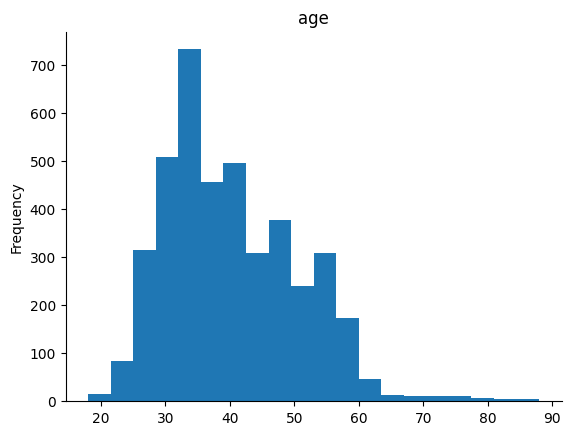

In [ ]:
housing_subsidy_df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

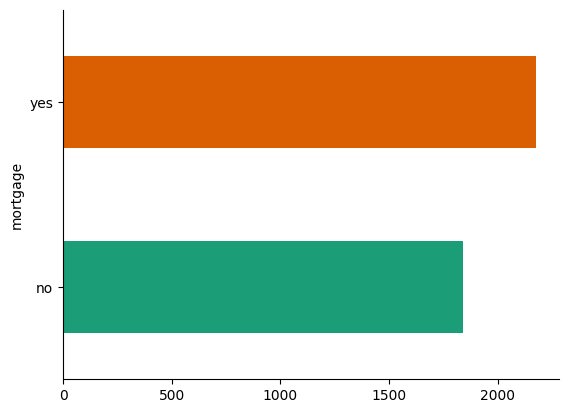

In [ ]:
housing_subsidy_df.groupby('mortgage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

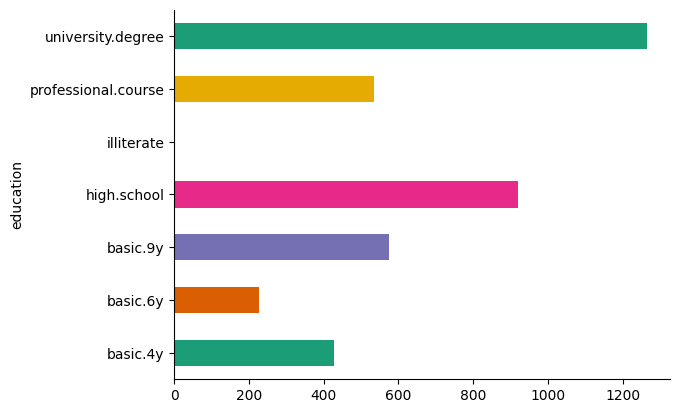

In [ ]:
housing_subsidy_df.groupby('education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

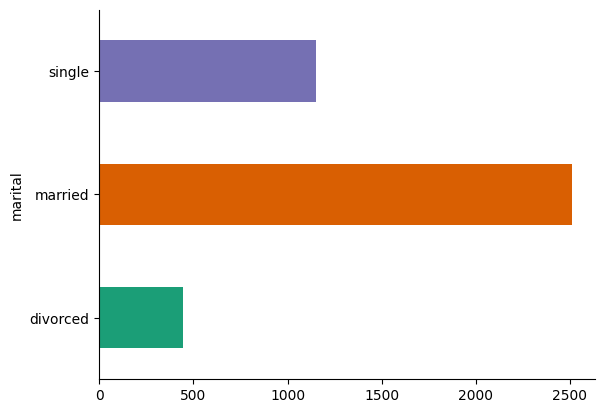

In [ ]:
housing_subsidy_df.groupby('marital').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

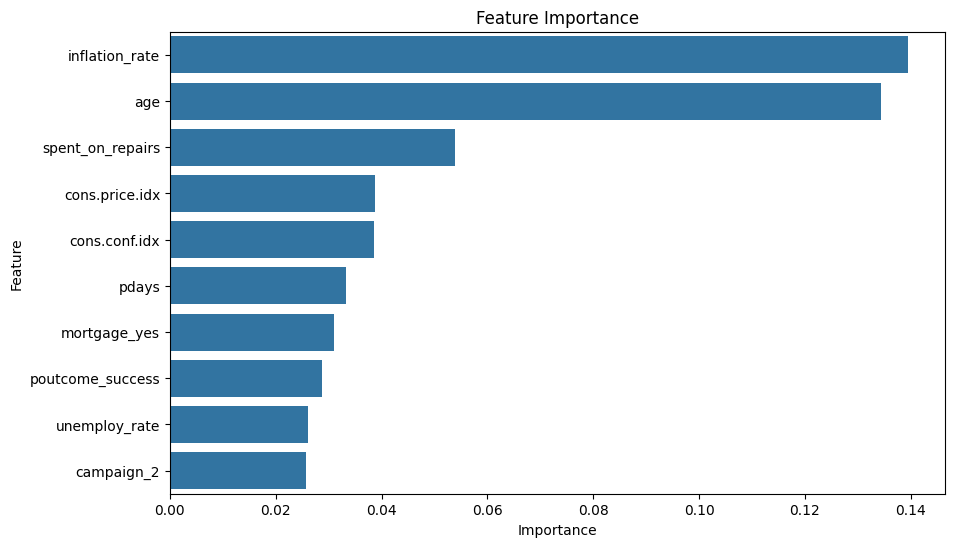

In [ ]:
#trying to get feature importantce:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Handle missing values (if any)
data= housing_subsidy_df.copy()
data = data.dropna()

# Encode categorical variables
categorical_cols = ['job', 'marital', 'education', 'taxLien', 'mortgage', 'taxbill_in_phl', 'contact', 'month', 'day_of_week', 'campaign', 'poutcome']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


# Split the data into training and test sets
X = data.drop('y_numeric', axis=1)
y = data['y_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model to get feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)[:10]

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()


In [ ]:
#Missing values
missing_values_over_zero = housing_subsidy_df.isnull().sum().loc[lambda x: x > 0]
print("Columns with Missing Values:")
print(missing_values_over_zero)

# List all categorical and numeric features
numeric_features = housing_subsidy_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = housing_subsidy_df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric Features:")
print(numeric_features)
print("\nCategorical Features:")
print(categorical_features)

# Identify binary columns (categorical with exactly 2 unique values)
binary_categorical_columns = housing_subsidy_df[categorical_features].nunique().loc[lambda x: x == 2].index.tolist()

print("\nBinary Categorical Columns:")
print(binary_categorical_columns)

# Identify categorical features with non-binary values and their unique counts
non_binary_categorical_columns = housing_subsidy_df[categorical_features].nunique().loc[lambda x: x > 2]

print("\nNon-Binary Categorical Columns and their Unique Values:")
print(non_binary_categorical_columns)

# Count of non-binary categorical features
count_non_binary_categorical = len(non_binary_categorical_columns)
print(f"\nNumber of Non-Binary Categorical Features: {count_non_binary_categorical}")

Columns with Missing Values:
job           39
marital       11
education    167
taxLien      803
mortgage     105
dtype: int64

Numeric Features:
['age', 'campaign', 'pdays', 'previous', 'unemploy_rate', 'cons.price.idx', 'cons.conf.idx', 'inflation_rate', 'spent_on_repairs', 'y_numeric']

Categorical Features:
['job', 'marital', 'education', 'taxLien', 'mortgage', 'taxbill_in_phl', 'contact', 'month', 'day_of_week', 'poutcome']

Binary Categorical Columns:
['taxLien', 'mortgage', 'taxbill_in_phl', 'contact']

Non-Binary Categorical Columns and their Unique Values:
job            11
marital         3
education       7
month          10
day_of_week     5
poutcome        3
dtype: int64

Number of Non-Binary Categorical Features: 6


In [ ]:
from sklearn.impute import SimpleImputer
df = housing_subsidy_df.copy()
# Impute missing values
# Numeric features imputed with mean
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

# Categorical features imputed with most frequent (mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Verify imputation
missing_values_after_imputation = df.isnull().sum()
print("\nMissing Values After Imputation:")
print(missing_values_after_imputation)

# Correctly encode the 'contact' column
df['contact'] = df['contact'].map({'telephone': 0, 'cellular': 1})

# Encoding other binary categorical features
for col in binary_categorical_columns:
    if col != 'contact':  # Skip 'contact' as it is already encoded
        df[col] = df[col].map({'yes': 1, 'no': 0})

# One-hot encode non-binary categorical features
df = pd.get_dummies(df, columns=non_binary_categorical_columns.index.tolist(), drop_first=True)

# Display the first few rows of the processed dataset
print("\nProcessed Dataset:")
print(df.head())

# Verify no missing values remain
print("\nMissing Values After Encoding:")
print(df.isnull().sum())



Missing Values After Imputation:
age                 0
job                 0
marital             0
education           0
taxLien             0
mortgage            0
taxbill_in_phl      0
contact             0
month               0
day_of_week         0
campaign            0
pdays               0
previous            0
poutcome            0
unemploy_rate       0
cons.price.idx      0
cons.conf.idx       0
inflation_rate      0
spent_on_repairs    0
y_numeric           0
dtype: int64

Processed Dataset:
    age  taxLien  mortgage  taxbill_in_phl  contact  campaign  pdays  \
0  30.0        0         1               1        1       2.0  999.0   
1  39.0        0         0               1        0       4.0  999.0   
2  25.0        0         1               1        0       1.0  999.0   
3  38.0        0         1               0        0       3.0  999.0   
4  47.0        0         1               1        1       1.0  999.0   

   previous  unemploy_rate  cons.price.idx  ...  month_may  

In [ ]:
#Feature engineering
df_engineered = df.copy()
# Interaction terms
df_engineered['age_campaign'] = df['age'] * df['campaign']
df_engineered['age_previous'] = df['age'] * df['previous']

# Aggregation features
df_engineered['total_contacts'] = df['campaign'] + df['previous']
df_engineered['econ_indicator'] = df['unemploy_rate'] * df['cons.price.idx']

# Boolean features
df_engineered['has_mortgage_and_tax_lien'] = ((df['mortgage'] == 1) & (df['taxLien'] == 1)).astype(int)

# Ratios and differences
df_engineered['repair_inflation_ratio'] = df['spent_on_repairs'] / df['inflation_rate']

# Domain-specific features
df_engineered['senior_homeowner'] = (df['age'] > 65).astype(int)

# Convert boolean columns to integers (if any)
for col in df.columns:
    if df[col].dtype == bool:
        df_engineered[col] = df[col].astype(int)

# Display the first few rows of the modified dataset
print("\nProcessed Dataset with New Features:")
df_engineered.head()


Processed Dataset with New Features:


,age,taxLien,mortgage,taxbill_in_phl,contact,campaign,pdays,previous,unemploy_rate,cons.price.idx,...,day_of_week_wed,poutcome_nonexistent,poutcome_success,age_campaign,age_previous,total_contacts,econ_indicator,has_mortgage_and_tax_lien,repair_inflation_ratio,senior_homeowner
0,30.0,0,1,1,1,2.0,999.0,0.0,-1.8,92.893,...,0,1,0,60.0,0.0,2.0,-167.2074,0,3883.549124,0
1,39.0,0,0,1,0,4.0,999.0,0.0,1.1,93.994,...,0,1,0,156.0,0.0,4.0,103.3934,0,1069.207003,0
2,25.0,0,1,1,0,1.0,999.0,0.0,1.4,94.465,...,1,1,0,25.0,0.0,1.0,132.2510,0,1053.627570,0
3,38.0,0,1,0,0,3.0,999.0,0.0,1.4,94.465,...,0,1,0,114.0,0.0,3.0,132.2510,0,1054.264973,0
4,47.0,0,1,1,1,1.0,999.0,0.0,-0.1,93.200,...,0,1,0,47.0,0.0,1.0,-9.3200,0,1239.751849,0


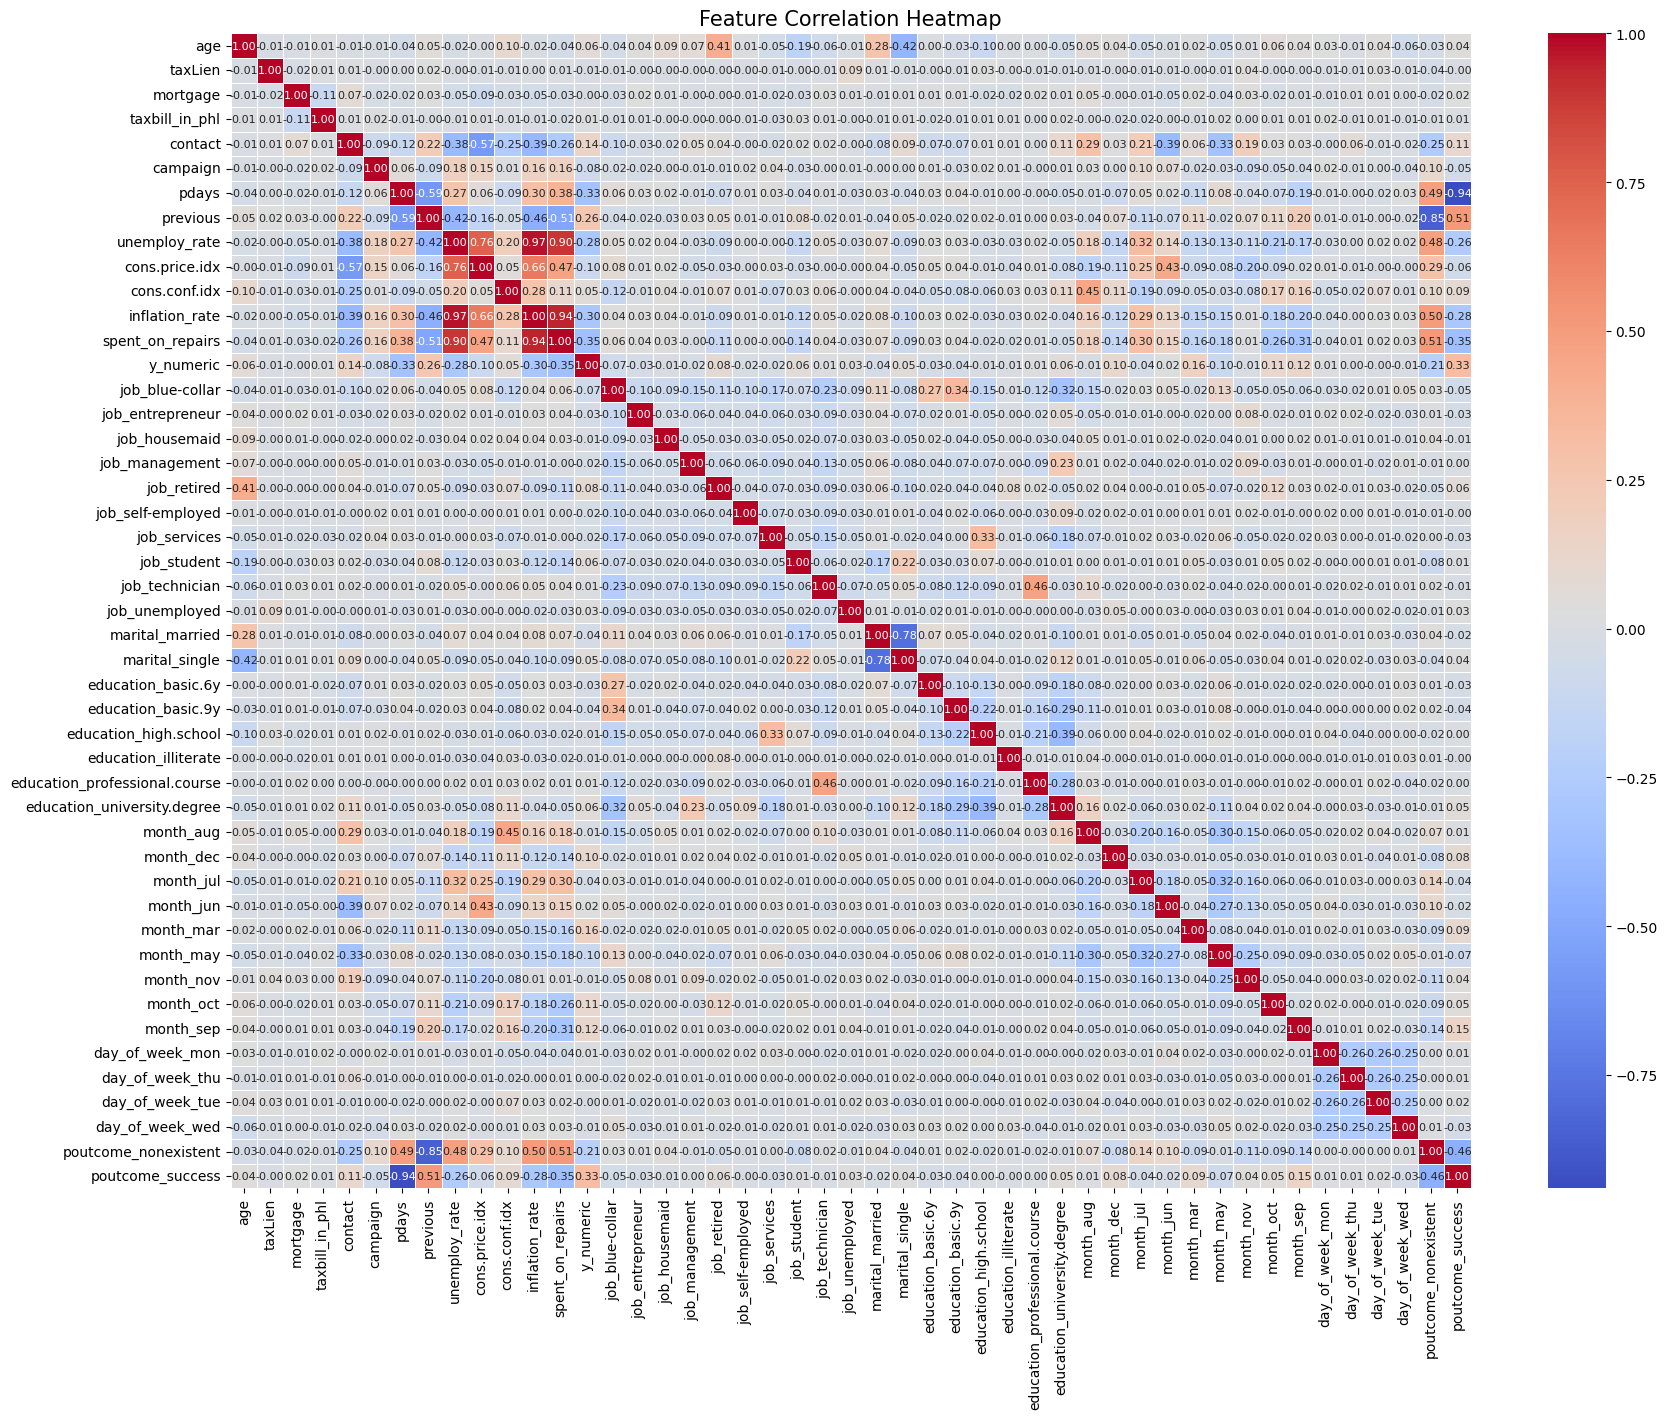

In [ ]:
# Generate the heatmap with improvements
plt.figure(figsize=(20, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Feature Correlation Heatmap', fontsize=15)
plt.show()

#Pretty terrible viz, can defintely do better with another way

In [ ]:
# Split the original dataset
X = df.drop('y_numeric', axis=1)
y = df['y_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Split the dataset with engineered features
X_engineered = df_engineered.drop('y_numeric', axis=1)
y_engineered = df_engineered['y_numeric']
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_engineered, y_engineered, test_size=0.35, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score

# Train logistic regression model on original dataset
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report (Original Dataset):")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score (Original Dataset): {roc_auc}")

# Train logistic regression model on engineered dataset
model_eng = LogisticRegression(max_iter=1000, random_state=42)
model_eng.fit(X_train_eng, y_train_eng)

# Predict on test set
y_pred_eng = model_eng.predict(X_test_eng)
y_proba_eng = model_eng.predict_proba(X_test_eng)[:, 1]

# Evaluate the model
print("Classification Report (Engineered Dataset):")
print(classification_report(y_test_eng, y_pred_eng))
roc_auc_eng = roc_auc_score(y_test_eng, y_proba_eng)
print(f"ROC AUC Score (Engineered Dataset): {roc_auc_eng}")


Classification Report (Original Dataset):
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1281
         1.0       0.67      0.19      0.29       161

    accuracy                           0.90      1442
   macro avg       0.79      0.59      0.62      1442
weighted avg       0.88      0.90      0.87      1442

ROC AUC Score (Original Dataset): 0.7651121745918609
Classification Report (Engineered Dataset):
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1281
         1.0       0.69      0.23      0.34       161

    accuracy                           0.90      1442
   macro avg       0.80      0.61      0.65      1442
weighted avg       0.89      0.90      0.88      1442

ROC AUC Score (Engineered Dataset): 0.7627702542171537


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import recall_score

# Calculate True Positive Rate (Sensitivity) for original model
tpr_original = recall_score(y_test, y_pred)
print(f"True Positive Rate (Original Model): {tpr_original}")

# Calculate True Positive Rate (Sensitivity) for engineered model
tpr_engineered = recall_score(y_test_eng, y_pred_eng)
print(f"True Positive Rate (Engineered Model): {tpr_engineered}")


True Positive Rate (Original Model): 0.18633540372670807
True Positive Rate (Engineered Model): 0.22981366459627328


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).